## Temporal Graph Networks


Till now, we have been focused on the *static* graphs where the graph structures and the node features are *fixed* over time. However, there are domains where the graph changes over time. 

Temporal graphs can be divided in two categories:
- **Static graphs with temporal signals:** The underlying graph structure does not change over time, but features and labels evolve over time.
        <center><img src="images/static_structure_dynamic_features.png" width="500"></center>
    
A main example is for traffic forcasting where graphs are based on traffic sensor data (e.g. the PeMS dataset) where each sensor is a node, and the edges are road connections. The geographical distribution of sensors in PeMS is shown below:
        
<center><img src="images/pems.ppm" width="400"></center>

- **Dynamic graphs with temporal signals:** The topology of the graph (the presence of nodes and edges), features, and labels evolve over time.
<center><img src="images/dynamic_structure_dynamic_features.png" width="500"></center>
A main example is in a social network where new edges are added when people make new friends, existing edges are removed when people stop being friends, and node features change as people change their attributes, e.g., when they change their career assuming that career is one of the node features.
<center><img src="images/Dynamic_Graphs.png" width="500"></center>

> Note:\
>Dynamic graphs can be divided into *discrete-time* and *continuous-time* categories as well. 

- A discrete-time dynamic graph (DTDG) is a sequence $[G^{(1)}, G^{(2)},...,G^{(\tau)}]$ of graph snapshots where each $G^{(t)} = \left(V^{(t)},A^{(t)},X^{(t)}\right)$ has vertices $V^{(t)}$, adjacency matrix $A^{(t)}$ and feature matrix $X^{(t)}$. DTDGs mainly appear in applications where data is captured at reguarly-spaced intervals.

<center><img src="images/DTDG.png" width="700"></center>
<center><small>Image from https://graph-neural-networks.github.io/static/file/chapter15.pdf</small></center> 

- A continuous-time dynamic graph (CTDG) is a pair $\left(G^{(t_0)},O\right)$ where ${G^{(t_0)}=\left(V^{(t_0)},A^{(t_0)},X^{(t_0)}\right)}$ is a static initial graph at initial state time $t_0$ and $O$ is a sequence of temporal observations/events. Each observation is a tuple of the form *(event, event type,timestamp)* where *event type* can be a node or edge addition, node or edge deletion, node feature update, etc. *event* represents the actual event that happened, and *timestamp* is the time at which the event occured:

<center><img src="images/CTDG.png" width="400"></center>
<center><small>Image from https://arxiv.org/pdf/2404.18211v1</small></center>

We focus on DTDG in this tutorial.

## Combining GNNs with sequence models

DTDGs are made up of several snapshots arranged in order over time, which can be treated as sequential data. Temporal patterns in DTDGs are identified by looking at the relationships between these snapshots. Recurrent Neural Networks (RNNs) are often combined with GNNs to create dynamic models for DTDGs. These combinations are generally grouped into two types: stacked architectures and integrated architectures.

- **Stacked dynamic GNNs:** The most straightforward way to model a discrete dynamic graph is to have a separate GNN handle each snapshot of the graph and feed the output of each GNN to a time series component, such as an RNN. This is illustrated in the following Figure: 

<center><img src="images/stacked_DTDG.png" width="400"></center>
<center><small>Image from https://arxiv.org/pdf/2404.18211v1</small></center>

One of most well-known approaches in this cateogry is Waterfall Dynamic-GCN. In this architectures, a GCN is stacked with an LSTM per node. More specifically, at first separate GCNs (with same parameters) handle each snapshot of the graph and next the output of each GNN is sequentially given to a LSTM. In fact, a separate LSTM is used per node (although the weights across the LSTMs are shared). The architecture is illustaretd in the following Figure:
<center><img src="images/waterfall.png" width="700"></center>
<center><small>Image from https://arxiv.org/pdf/2005.07496</small></center>

The figure shows a network working on sequences of four snapshots of a graphs composed
of five vertices. The first GCN layer acts as four copies of a regular GCN layer, each one working on a snapshot of the sequence of the graphs. The output of this first layer is processed by the LSTM layer that acts as five copies of a LSTM, each one working on a nodes of the graphs.
The final fully-coonected (FC) layer produces the $C$-class probability vector for each nodes of every snapshot of the sequence. This layer, which produces the $C$-class probability vector for each node and for each instant of the sequence, can be seen as 5 x 4 copies of a FC layer.

- **Integrated dynamic GNNs**: 

Integrated DGNNs are networks that combine GNNs and RNNs in one layer and thus combine modelling of the
spatial and the temporal domain in that one layer.

One major break-through approach in this category is <i>**EvolveGCN**</i>. <u>EvolveGCN applies Temporal neural networks such as RNNs to the *GCN parameters* themselves.</u> Note that GCN parameters are considered temporal and not the embeddings. In EvolveGCN, the GCN evolves over time to produce relevant temporal node embeddings. The following figure illustrates a high-level view of EvolveGCN’s architecture to produce node embeddings for a static or dynamic graph with temporal signal:

<center><img src="images/Evolvegcn.png" width="700"></center>
<center><small>image from Labonne, Maxime. "Hands-On Graph Neural Networks Using Python: Practical techniques and architectures for building powerful graph and deep learning apps with PyTorch". Packt Publishing Ltd, 2023.</small></center>

but how to use RNN-based models to update the parameters of GCN according to the timesteps? EvolveGCN proposed two similar architectures, which we introduce only one of them, manily EvolveGCN-H. The main idea is shown below:

<center><img src="images/Evolvegcn-h.png" width="700"></center>

EvolveGCN-H utilizes a Gated Recurrent Unit (GRU) in place of a standard RNN. The GRU, a simplified variant of the Long Short-Term Memory (LSTM) unit, offers similar performance with fewer parameters. In this architecture, the hidden state of the GRU corresponds to the weight matrix of the GCN. 

Let:
- $H_t^{(l)}$ denote the node embeddings produced at the $l$-th layer and at the timestep $t$; (Note that $H_t^{(0)}=X$) 
- $W_{(t-1)}^{(l)}$ be the weight matrix for the GCN at layer $l$ and previous timestep $t-1$. 

At each time step $t$, the GRU takes the node embeddings from the previous layer, $H^{(l)}_t$, as input, and uses the GCN's weight matrix, $W^{(l)}_{t-1}$, as its hidden state. It then updates the $W$ matrix for layer $l$ at time $t$ as follows:

\begin{equation*}
W_t^{(l)} = GRU(H_t^{(l)}, W_{t-1}^{(l)})
\end{equation*}

The updated weight matrix is used to calculate the node embeddings for the $l+1$ layer:

\begin{equation*}
H^{(l+1)}_t = GCN(A_t, H_t^{(l)}, W_t^{(l)})
\end{equation*}





### Example: Using Temporal Graphs for Action based recognition in Pytorch


Skeleton-based action recognition leverages human skeletal data to identify and classify actions or gestures. This approach is particularly effective because skeleton data provides a structured and abstract representation of body movements, capturing key joint positions and their interactions. 

<center><img src="images/skeleton_as_graph.png" width="300"></center>

- Skeleton Data: The input consists of sequences of joint positions, typically represented as a set of coordinates for each joint in a human skeleton. Each joint's position is recorded over time, creating a sequence of frames that shows how the skeleton moves.
- Graph Representation: In the graph-based approach, each joint is treated as a node in a graph, and edges represent the connections between joints (e.g., bones). This graph captures the spatial relationships and constraints between different parts of the body.
- Spatio-Temporal Modeling:

    - Spatial Analysis: To analyze the spatial relationships between joints, graph convolutional layers are used. These layers capture how the joints interact with each other within a single frame.
    - Temporal Analysis: To understand how these interactions change over time, temporal convolutional layers process sequences of frames. This helps in learning the dynamic patterns of movement across time.

Spatio-Temporal Graph Convolutional Networks (ST-GCNs) are a pioneering approach designed to handle data that involves both spatial and temporal dimensions, particularly suited for tasks like action recognition from skeleton data. 
In ST-GCNs, skeleton data is represented as a graph where joints (body parts) are nodes and their connections (bones) are edges. This graph structure captures the spatial relationships between different joints in a single frame.
ST-GCNs are composed of several layers. In each layer, ST-GCNs use GCN to apply convolution operations on the graph structure, aggregating information from neighboring nodes (joints) to learn how each joint's position relates to others. This helps in capturing the spatial patterns of body movements. Since actions involve sequences of movements over time, ST-GCNs also include one-dimensional temporal convolutional layers. These layers process sequences of frames, allowing the model to learn how the spatial configuration of joints changes over time. Temporal convolutions help capture dynamic patterns and transitions in the motion data.

In this section, we will develop a basic implementation of the ST-GCN model using PyTorch Geometric, focusing on skeleton-based action recognition with the UTD-MHAD dataset.

> The skeleton joint order in UTD-MAD dataset: \
    head,
    shoulder_center,
    spine,
    hip_center,
    left_shoulder,
    left_elbow,
    left_wrist,
    left_hand,
    right_shoulder,
    right_elbow,
    right_wrist,
    right_hand,
    left_hip,
    left_knee,
    left_ankle,
    left_foot,
    right_hip,
    right_knee,
    right_ankle,
    right_foot,

> UTD-MHAD dataset consists of 27 different actions: \
    right arm swipe to the left,
    right arm swipe to the right,
    right hand wave,
    two hand front clap,
    right arm throw,
    cross arms in the chest,
    basketball shoot,
    right hand draw x,
    right hand draw circle (clockwise),
    right hand draw circle (counter clockwise),
    draw triangle,
    bowling (right hand),
    front boxing,
    baseball swing from right,
    tennis right hand forehand swing,
    arm curl (two arms),
    tennis serve,
    two hand push,
    right hand knock on door,
    right hand catch an object,
    right hand pick up and throw,
    jogging in place,
    walking in place,
    sit to stand,
    stand to sit,
    forward lunge (left foot forward),
    squat (two arms stretch out)

Each skeleton data is a 20 x 3 x num_frame matrix. Each row of a skeleton frame corresponds to three spatial coordinates of a joint. 

The UTD-MAD dataset features a total of 8 subjects performing a variety of actions. It includes 27 distinct action categories, with each subject performing four takes (repetitions) of each action. Specifically, there are about 1,280 action sequences captured across all subjects and actions. This diversity in subjects and takes provides a comprehensive foundation for developing and evaluating action recognition algorithms.

We use even subjects (S2, S4, S6, S8) to train, Odd Subjects (S1, S3, S5, S7) to test

In [9]:
import os
from scipy.io import loadmat
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
from random import shuffle
import numpy as np
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = F.relu(x)
        return x

class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(TemporalConv, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), stride=(stride, 1), padding=(padding, 0))

    def forward(self, x):
        # Input x is expected to be of shape (batch_size, in_channels, num_frames, num_nodes)
        return self.conv(x)
class STGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(STGCNLayer, self).__init__()
        self.gcn = GCNLayer(in_channels, out_channels)
        self.tcn1 = TemporalConv(in_channels, in_channels, kernel_size, stride)
        self.tcn2 = TemporalConv(out_channels, out_channels, kernel_size, stride)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)  # Batch normalization
        self.dropout = nn.Dropout(0.3)  # Dropout layer

    def forward(self, x, edge_index):
        # x is expected to be of shape (batch_size, num_frames, num_nodes, in_channels)
        batch_size, num_frames, num_nodes, in_channels = x.size()

        # Apply GCN
        x = self.gcn(x, edge_index)

        # Reshape x back to (batch_size, num_frames, num_nodes, out_channels)
        out_channels = x.size(-1)
        x = x.view(batch_size, num_frames, num_nodes, out_channels)

        # Transpose for temporal convolution: (batch_size, out_channels, num_frames, num_nodes)
        x = x.permute(0, 3, 1, 2)

        # Apply Temporal Convolution
        x = self.tcn2(x)

        x = self.bn(x)  # Batch normalization
        x = self.dropout(x)  # Dropout


        # Apply ReLU activation
        x = self.relu(x)

        # Transpose back: (batch_size, num_frames, num_nodes, out_channels)
        x = x.permute(0, 2, 3, 1)

        return x

class STGCN(nn.Module):
    def __init__(self, in_channels, num_classes, num_nodes, num_layers=3, hidden_dim=64, kernel_size=3, stride=1):
        super(STGCN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(STGCNLayer(in_channels, hidden_dim, kernel_size, stride))
        for _ in range(1, num_layers):
            self.layers.append(STGCNLayer(hidden_dim, hidden_dim, kernel_size, stride))

        self.fc = nn.Linear(hidden_dim*num_nodes, num_classes)
        self.num_nodes = num_nodes


    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)

        # Global pooling (e.g., mean pooling over time and nodes)
        x = x.view(x.size(0), -1, self.num_nodes * x.size(-1))
        x = x.max(axis=1)[0] # Average over time

        # Fully connected layer for classification
        x = self.fc(x)

        return x

model = STGCN(in_channels=3, num_classes=27, num_nodes=20,num_layers=3,kernel_size=5, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train = []
test = []
for file in os.listdir("Skeleton/"):
    if file.endswith("mat"):
        if "s2" in file or "s4" in file or "s6" in file or "s8" in file:
            train.append((loadmat("Skeleton/"+file)['d_skel'], file.split("_")[0]))
        else:
            test.append((loadmat("Skeleton/"+file)['d_skel'],file.split("_")[0]))

# Skeleton structure (joints connections) for UTD-MHAD
skeleton_edges = [
    (0, 1),  # head → shoulder_center
    (1, 2),  # shoulder_center → spine
    (2, 3),  # spine → hip_center

    (1, 4),  # shoulder_center → left_shoulder
    (4, 5),  # left_shoulder → left_elbow
    (5, 6),  # left_elbow → left_wrist
    (6, 7),  # left_wrist → left_hand

    (1, 8),  # shoulder_center → right_shoulder
    (8, 9),  # right_shoulder → right_elbow
    (9, 10), # right_elbow → right_wrist
    (10, 11),# right_wrist → right_hand

    (3, 12), # hip_center → left_hip
    (12, 13),# left_hip → left_knee
    (13, 14),# left_knee → left_ankle
    (14, 15),# left_ankle → left_foot

    (3, 16), # hip_center → right_hip
    (16, 17),# right_hip → right_knee
    (17, 18),# right_knee → right_ankle
    (18, 19) # right_ankle → right_foot
]


def create_graphs_from_tuple(in_tuple, use_relative_coordinates=True):
    action = int(in_tuple[1].split('a')[1]) - 1
    frames = in_tuple[0]  # Shape: (20, 3, num_frames)
    
    # Compute relative coordinates if required
    if use_relative_coordinates:
        central_joint_idx = 2  # Assuming the spine is the central joint
        central_joint_coords = frames[central_joint_idx, :, :]
        central_joint_coords = np.expand_dims(central_joint_coords, axis=0) 
        frames = frames - central_joint_coords

    # Stack all frames into a single tensor of shape (num_frames, num_nodes, in_channels)
    num_frames = frames.shape[2]
    node_features = torch.tensor(frames.transpose(2, 0, 1), dtype=torch.float).unsqueeze(0)
    # The transpose converts the shape to (num_frames, num_nodes, in_channels)
    
    # Convert edge list to tensor
    edge_index = torch.tensor(skeleton_edges, dtype=torch.long).t().contiguous()

    # Create a single PyG Data object containing the entire temporal sequence
    temporal_graph = Data(x=node_features, edge_index=edge_index, y=action)
    
    return temporal_graph



train_graph_snapshots = [create_graphs_from_tuple(seq) for seq in train]
test_graph_snapshots = [create_graphs_from_tuple(seq) for seq in test]

train_loss = []
for epoch in range(150):
    model.train()
    losses = []
    shuffle(train_graph_snapshots)
    for index,graph_snapshots in enumerate(train_graph_snapshots):
        optimizer.zero_grad()
        # Forward pass through the model
        out = model(graph_snapshots.x, graph_snapshots.edge_index)  # Pass graph snapshots for one action sequence
        labels = torch.as_tensor([graph_snapshots.y])
        # Compute loss
        loss = criterion(out, labels)
        # Backpropagation
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.array(losses).mean())
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for graph_snapshots in train_graph_snapshots:
            # Forward pass through the model
            out = model(graph_snapshots.x, graph_snapshots.edge_index)  # Pass graph snapshots for one action sequence
            label = torch.as_tensor([graph_snapshots.y])
            pred = torch.argmax(out)
            if pred.item() == label.item():
                correct +=1
            total +=1
        print(f'Epoch {epoch+1}, Loss: {np.array(losses).mean()}, Train accuracy: {correct/total}')
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for graph_snapshots in test_graph_snapshots:
            # Forward pass through the model
            out = model(graph_snapshots.x, graph_snapshots.edge_index)  # Pass graph snapshots for one action sequence
            label = torch.as_tensor([graph_snapshots.y])
            # Compute loss
            pred = torch.argmax(out)
            if pred.item() == label.item():
                correct +=1
            total +=1
        print(f'Test accuracy: {correct/total}')



Epoch 1, Loss: 3.7029674391413843, Train accuracy: 0.13488372093023257
Test accuracy: 0.12296983758700696
Epoch 2, Loss: 2.3595689116522323, Train accuracy: 0.27906976744186046
Test accuracy: 0.271461716937355
Epoch 3, Loss: 1.866786751151085, Train accuracy: 0.35348837209302325
Test accuracy: 0.3874709976798144
Epoch 4, Loss: 1.5716009542259366, Train accuracy: 0.4744186046511628
Test accuracy: 0.4617169373549884
Epoch 5, Loss: 1.2992200438604624, Train accuracy: 0.5441860465116279
Test accuracy: 0.4895591647331787
Epoch 6, Loss: 1.1048050865124868, Train accuracy: 0.6046511627906976
Test accuracy: 0.5707656612529002
Epoch 7, Loss: 0.9868400013664478, Train accuracy: 0.6372093023255814
Test accuracy: 0.5893271461716937
Epoch 8, Loss: 0.8508805212198599, Train accuracy: 0.6093023255813953
Test accuracy: 0.6032482598607889
Epoch 9, Loss: 0.737859922967889, Train accuracy: 0.6813953488372093
Test accuracy: 0.6890951276102089
Epoch 10, Loss: 0.659264627443596, Train accuracy: 0.6604651162

Here is an example of a constructed skeleton graph from frame #10 in a sequence of training data:

<Figure size 640x480 with 0 Axes>

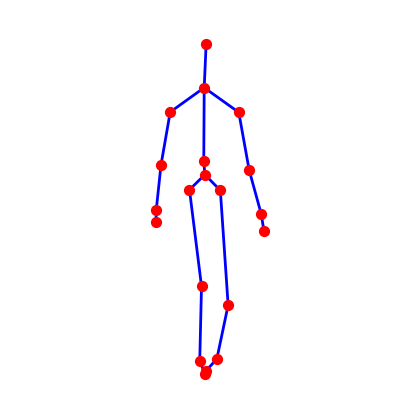

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

num_frames = train_graph_snapshots[1].x.shape[1]
node_features = train_graph_snapshots[0].x.squeeze().permute(1,2,0)


# Visualize the first frame as an example
frame_num = 10
joint_positions = node_features[:, :, frame_num]

G = nx.Graph()
for i, feature in enumerate(joint_positions.squeeze()):
    G.add_node(i, pos=feature)
G.add_edges_from(skeleton_edges)

pos = {i: [x[0].item(),x[1].item()] for i, x in enumerate(joint_positions.squeeze())}
fig = plt.figure()
plt.figure(figsize=(4, 4))
nx.draw(G, pos=pos, node_color='red',edge_color="blue",width=2,node_size=50)
plt.axis("equal")
plt.show()
